In [1]:
import numpy as np
import pandas as pd
import os
import calendar
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns =100
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import SimpleRNN, Dense
import warnings
from contextlib import nullcontext
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def readAllCSV():

  month_mapping = {month: index for index, month in enumerate(calendar.month_name) if month}

  file_list = os.listdir('data')

  file_list = sorted(file_list, key=lambda x: month_mapping.get(x.split('.')[0]))
  dfs = []
  for file_name in file_list:
      
      file_path = os.path.join('data', file_name)
      df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
      dfs.append(df)
  return dfs

def extractUsefulInfo(table, columns):

  df = table[columns]
  df = df.drop(df.index[0])
  df[columns] = df[columns].astype(float)
  print("Printing NaN's")
  print(df.isna().sum())
  df.dropna(inplace=True)
  return df


def plots(df,column,q_low,q_hi):
  # Set the style of the plot
  sns.set_style("whitegrid")

  # Set the thresholds
  low_threshold = df[column].quantile(q_low)
  high_threshold = df[column].quantile(q_hi)

  # Filter the data
  filtered_data = df[
      (df[column] >= low_threshold) &
      (df[column] <= high_threshold)
  ]

  # Downsampling the data
  max_data_points = 2000  # Maximum number of data points to plot
  if len(filtered_data) > max_data_points:
      indices = np.linspace(0, len(filtered_data) - 1, max_data_points, dtype=int)
      downsampled_data = filtered_data.iloc[indices]
  else:
      downsampled_data = filtered_data

  # Create the plot using Seaborn
  plt.figure(figsize=(10, 6))
  sns.lineplot(x='date', y=column, data=downsampled_data)

  # Set the x-axis tick labels
  num_ticks = 10
  step = len(downsampled_data) // num_ticks
  x_ticks = downsampled_data['date'][::step]
  plt.xticks(x_ticks, rotation=90)

  # Set the plot labels and title
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title('Visualization of ' + column + ' (Filtered)')

  # Display the plot
  plt.show()


In [3]:
df_list = readAllCSV()

C:\Users\msi\AppData\Local\Temp\ipykernel_24872\2314126731.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  df_list = readAllCSV()
C:\Users\msi\AppData\Local\Temp\ipykernel_24872\2314126731.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  df_list = readAllCSV()
C:\Users\msi\AppData\Local\Temp\ipykernel_24872\2314126731.py:1: DtypeWarning: Columns (4,

In [4]:
for i in range(6):
    df_list[i] = df_list[i].drop(df_list[i].index[0])
    df_list[i]['date1']  = pd.to_datetime(df_list[i]['date'],format='%d/%m/%Y %H:%M' ,errors='coerce')
    df_list[i]['date2'] =pd.to_datetime(df_list[i]['date'], format= '%Y-%m-%d %H:%M:%S.%f', errors='coerce')
    df_list[i]['combined_date'] = df_list[i]['date1'].combine_first(df_list[i]['date2'])
    df_list[i]=df_list[i].drop(['date1'], axis=1)
    df_list[i]=df_list[i].drop(['date2'], axis=1)
    df_list[i]=df_list[i].drop(['date'], axis=1)
    df_list[i]['date'] = df_list[i]['combined_date']
    df_list[i].drop(['combined_date'], axis=1)

In [5]:
# june = df_list[1]
# june['date1']  = pd.to_datetime(june['date'],format='%d/%m/%Y %H:%M' ,errors='coerce')#, infer_datetime_format=True)# , errors='ignore')
# june['date2'] =pd.to_datetime(june['date'], format= '%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# june['combined_date'] = june['date1'].combine_first(june['date2'])
# june.drop(['date1'], axis=1)
# june.drop(['date2'], axis=1)
# june.drop(['date'], axis=1)
# june['date'] = june['combined_date']
# june.drop(['combined_date'], axis=1)
# june['date'] 

In [6]:
all_months = pd.concat(df_list)
all_months= all_months.sort_values(by='date')
all_months= all_months.reset_index(drop=True)
all_months

,Unnamed: 0,_id,total_feed_perc_pv,clinker_perc_pv,limestone_perc_pv,slag_perc_pv,gypsum_perc_pv,pozzolane_perc_pv,fly_ash_1_perc_pv,fly_ash_2_perc_pv,clinker_perc_sp,limestone_perc_sp,slag_perc_sp,gypsum_perc_sp,pozzolane_perc_sp,fly_ash_1_perc_sp,fly_ash_2_perc_sp,total_feed_ton/h_pv,clinker_ton/h_pv,limestone_ton/h_pv,slag_ton/h_pv,gypsum_ton/h_pv,pozzolane_ton/h_pv,fly_ash_1_ton/h_pv,fly_ash_2_ton/h_pv,total_feed_ton/h_sp,slag_ton/h_sp,limestone_ton/h_sp,clinker_ton/h_sp,pozzolane_ton/h_sp,gypsum_ton/h_sp,fly_ash_1_ton/h_sp,fly_ash_2_ton/h_sp,mill_injection_water_perc_sp,mill_motor_pwr_kw_pv,recirculation_damper_perc_pv,recirculation_damper_perc_sp,fresh_air_damper_perc_pv,fresh_air_damper_perc_sp,main_fan_pwr_kw_pv,main_fan_speed_rpm_pv,main_bf_out_press_mbar_pv,main_bf_dp_mbar_pv,grinding_pressure_bar_sp,grinding_pressure_bar_pv,bucket_elv_mtr_pwr_kw_pv,mill_in_pres_mbar_pv,mill_in_pres_mbar_sp,mill_in_temp_c_pv,mill_exit_temp_c_pv,...,fineness_perc_pv,moisture_slag_perc_pv,moisture_pozzolane_perc_pv,moisture_clinker_perc_pv,moisture_limestone_perc_pv,moisture_gypsum_perc_pv,moisture_fly_ash_1_perc_pv,moisture_fly_ash_2_perc_pv,time_sample_taken_cpii_pv,cement_type_cpii_bool_pv,cement_type_cpiv_bool_pv,mill_operation,combined_date,date,blaine_cm3_g_pv,total_feed_ton_h_pv,clinker_ton_h_pv,limestone_ton_h_pv,slag_ton_h_pv,gypsum_ton_h_pv,pozzolane_ton_h_pv,fly_ash_1_ton_h_pv,fly_ash_2_ton_h_pv,total_feed_ton_h_sp,slag_ton_h_sp,limestone_ton_h_sp,clinker_ton_h_sp,pozzolane_ton_h_sp,gypsum_ton_h_sp,fly_ash_1_ton_h_sp,fly_ash_2_ton_h_sp,fan_pwr_kw_pv,fan_speed_rpm_pv,bf_out_press_mbar_pv,bf_dp_mbar_pv,mill_in_press_mbar_pv,mill_in_press_mbar_sp,mill_out_press_mbar_pv,mill_injection_water_m3_h_pv,mill_vibration_mm_s_pv,gearbox_1_vibration_mm_s_pv,gearbox_2_vibration_mm_s_pv,hopper_level_mg_m3_pv,grinding_aid_l_h_pv,grinding_aid_perc_sp,fan_speed_perc_pv,fan_speed_perc_sp,bf_dp_mbar_sp,is_enable_sp,is_clicked_sp
0,0.0,5cd56ee6dd802735d859c2c5,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,...,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,2019-05-10 09:30:30.000,2019-05-10 09:30:30.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,5cd56ee6dd802735d859c2c6,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,...,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,2019-05-10 09:30:30.029,2019-05-10 09:30:30.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,5cd56ee6dd802735d859c2c7,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,...,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,2019-05-10 09:30:30.058,2019-05-10 09:30:30.058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,5cd56ee6dd802735d859c2c8,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR,ERROR

In [7]:
string_value = 'ERROR'

# Remove rows that contain the specific string value
all_months = all_months[~all_months.apply(lambda row: string_value in row.values, axis=1)]

In [8]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']


all_months_new = extractUsefulInfo(all_months,columns)
all_months_new['date'] = all_months['date']
all_months_new

Printing NaN's
separator_speed_rpm_pv      16
mill_dp_mbar_pv             19
separator_pwr_kw_pv         21
cement_type_cpii_bool_pv    22
cement_type_cpiv_bool_pv    17
mill_operation              22
dtype: int64


,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,cement_type_cpii_bool_pv,cement_type_cpiv_bool_pv,mill_operation,date
4976,746.87,31.37,56.83,0.0,1.0,1.0,2019-05-10 11:12:00
6222,717.51,29.79,60.41,0.0,1.0,1.0,2019-05-10 11:24:00
6278,735.89,30.51,55.76,0.0,1.0,1.0,2019-05-10 11:24:30
6333,736.68,31.61,55.89,0.0,1.0,1.0,2019-05-10 11:25:00
6389,747.61,33.71,56.06,0.0,1.0,1.0,2019-05-10 11:25:30
...,...,...,...,...,...,...,...
464287,529.50,32.36,58.25,1.0,0.0,0.0,2019-10-31 23:57:00
464288,529.60,34.87,57.40,1.0,0.0,1.0,2019-10-31 23:57:00
464289,530.13,35.19,57.69,1.0,0.0,1.0,2019-10-31 23:58:00
464290,529.87,36.59,57.52,1.0,0.0,1.0,2019-10-31 23:58:00


In [9]:
# gia to deutero
# columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv',
#            'cement_type_cpiv_bool_pv', 'mill_operation','total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv',
#            'main_fan_speed_rpm_pv', 'separator_speed_rpm_pv', 'grinding_pressure_bar_pv',
#            'mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 'mill_dp_mbar_pv']

# all_months_new = extractUsefulInfo(all_months,columns)
# all_months_new['date'] = all_months['date']
# all_months_new


In [10]:
# columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']

# june_first = extractUsefulInfo(june,columns)
# june_first['date'] = june['date']

In [11]:

cement_1 = all_months_new[(all_months_new['cement_type_cpiv_bool_pv'] == 1) & (all_months_new['cement_type_cpii_bool_pv'] == 0) & (all_months_new['mill_operation'] == 1)]
mean_value = all_months_new['separator_pwr_kw_pv'].mean()
threshold = 0.1 * mean_value
threshold
cement_1 = cement_1[cement_1['separator_pwr_kw_pv'] >= threshold]

In [12]:

cement_2 = all_months_new[(all_months_new['cement_type_cpiv_bool_pv'] == 1) & (all_months_new['cement_type_cpii_bool_pv'] == 0) & (all_months_new['mill_operation'] == 1)]
mean_value = all_months_new['separator_pwr_kw_pv'].mean()
threshold = 0.1 * mean_value
threshold
cement_2 = cement_2[cement_2['separator_pwr_kw_pv'] >= threshold]

In [13]:

# cement_1 = june_first[(june_first['cement_type_cpiv_bool_pv'] == 1) & (june_first['cement_type_cpii_bool_pv'] == 0) & (june_first['mill_operation'] == 1)]
# mean_value = cement_1['separator_pwr_kw_pv'].mean()
# threshold = 0.1 * mean_value
# threshold
# cement_1 = cement_1[cement_1['separator_pwr_kw_pv'] >= threshold]

# cement_2 = june_first[(june_first['cement_type_cpiv_bool_pv'] == 0) & (june_first['cement_type_cpii_bool_pv'] == 1) & (june_first['mill_operation'] == 1)]

# mean_value = cement_2['separator_pwr_kw_pv'].mean()
# threshold = 0.1 * mean_value
# threshold
# cement_2 = cement_2[cement_2['separator_pwr_kw_pv'] >= threshold]

In [14]:
print(cement_1.shape)
print(cement_2.shape)

(242510, 7)
(242510, 7)


In [15]:
def PrepareDataset(data, int_cols,numeric_cols):
    filtered_df = cement_1.groupby('date').mean().reset_index()
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])

    start_date = pd.to_datetime('2019-05-01 00:00:00')
    end_date = pd.to_datetime('2019-11-01 00:00:00')
    interval = pd.Timedelta(seconds=30)

    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    date_range = pd.date_range(start=start_date, end=end_date, freq=interval)

    missing_dates = date_range[~date_range.isin(filtered_df['date'])]
    missing_df = pd.DataFrame({'date': missing_dates})

    missing_df = missing_df[~missing_df['date'].isin(filtered_df['date'])]
    missing_df = missing_df.merge(filtered_df, on='date', how='outer')
    missing_df = missing_df.sort_values('date').ffill().bfill()

    filtered_df = pd.concat([filtered_df, missing_df])

    filtered_df[int_cols] = filtered_df[int_cols].applymap(lambda x: 0 if x < 1 else x)

    filtered_df = filtered_df.groupby('date').mean().reset_index()

    filtered_df = filtered_df.set_index('date')

    preceding_dates = missing_dates - interval
    following_dates = missing_dates + interval

    missing_indices = (preceding_dates.isin(filtered_df.index)) & (following_dates.isin(filtered_df.index))

    preceding_rows = filtered_df.loc[preceding_dates[missing_indices]]
    following_rows = filtered_df.loc[following_dates[missing_indices]]

    mean_values = (preceding_rows[numeric_cols].values + following_rows[numeric_cols].values) / 2
    mean_values = np.nan_to_num(mean_values, nan=0)

    new_rows = pd.DataFrame(mean_values, columns=filtered_df.columns)
    new_rows.index = missing_dates[missing_indices]

    new_rows[int_cols] = new_rows[int_cols].applymap(lambda x: 0 if x < 1 else x)

    filtered_df = pd.concat([filtered_df, new_rows])

    filtered_df = filtered_df.sort_index().reset_index()
    filtered_df = filtered_df.rename(columns={filtered_df.columns[0]: 'date'})

    filtered_df[int_cols] = filtered_df[int_cols].applymap(lambda x: 0 if x < 1 else x)
    filtered_df = filtered_df.groupby('date').mean().reset_index()

    duplicate_rows = filtered_df.duplicated(subset=filtered_df.columns[1:], keep='last')

    filtered_df = filtered_df[~duplicate_rows]

    filtered_df = filtered_df.drop(filtered_df.index[-1])

    filtered_df= filtered_df.sort_values('date')
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

In [16]:
int_cols = ['cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']
numeric_cols = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']

filtered_df = PrepareDataset(cement_1,int_cols,numeric_cols)

In [17]:
filtered_df

,date,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,cement_type_cpii_bool_pv,cement_type_cpiv_bool_pv,mill_operation
0,2019-05-10 11:23:00,746.87000,31.37000,56.83000,0.0,1.0,1.0
1,2019-05-10 11:23:30,739.53000,30.97500,57.72500,0.0,1.0,1.0
2,2019-05-10 11:24:00,717.51000,29.79000,60.41000,0.0,1.0,1.0
3,2019-05-10 11:24:30,735.89000,30.51000,55.76000,0.0,1.0,1.0
4,2019-05-10 11:25:00,736.68000,31.61000,55.89000,0.0,1.0,1.0
...,...,...,...,...,...,...,...
242426,2019-10-31 23:52:30,795.92375,36.76000,57.31500,0.0,1.0,1.0
242427,2019-10-31 23:53:00,796.04000,36.97000,57.39000,0.0,1.0,1.0
242428,2019-10-31 23:53:30,795.90875,37.06250,57.45750,0.0,1.0,1.0
242429,2019-10-31 23:54:00,795.51500,37.34000,57.66000,0.0,1.0,1.0


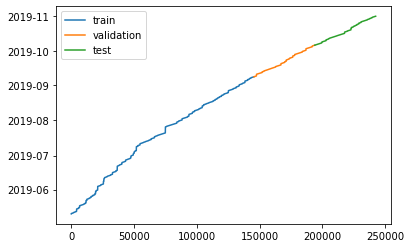

In [18]:
train_set = filtered_df[:int(6*len(filtered_df)/10)]['date']
validation_set = filtered_df[int(6*len(filtered_df)/10):int(8*len(filtered_df)/10)]['date']
test_set = filtered_df[int(8*len(filtered_df)/10):]['date']

train_set.plot(label='train')
validation_set.plot(label='validation')
test_set.plot(label='test')

plt.legend()

In [19]:
def build_dset(dset,col, lookback, horizon):
    dset = dset[col]
    data = pd.concat([dset.shift(-i) for i in range(lookback+horizon)], axis=1).dropna()

    return data.iloc[:, :lookback], data.iloc[:, lookback:]

In [20]:
train_set = filtered_df[:int(6*len(filtered_df)/10)]
validation_set = filtered_df[int(6*len(filtered_df)/10):int(8*len(filtered_df)/10)]
test_set = filtered_df[int(8*len(filtered_df)/10):]

In [21]:
def create_Windows(set):
    lookback = 20
    horizon = 10
    columns = ['date', 'separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv']
    input_columns = ['separator_speed_rpm_pv','mill_dp_mbar_pv']
    X_list = []
    tmp = []
    for col in columns[:-1]:
        x, _ = build_dset(set, col, lookback, horizon)
        X_list.append(x)




    # remove windows that will have missing dates
    threshold = lookback * pd.Timedelta(seconds=30)
    index_toremove = []
    for index, row in X_list[0].iterrows():
        t1 = row.iloc[0]
        t2 = row.iloc[-1]
        difference = t2 - t1

        if (difference > threshold ):
            index_toremove.append(index)
            
    mask = ~X_list[0].index.isin(index_toremove)

    for i in range(len(X_list)):
        X_list[i] = X_list[i].loc[mask]




    for en in range(0,lookback):
        tmp.append(pd.concat([df.iloc[:, en] for df in X_list[1:]], axis=1))

    x_train = pd.concat(tmp, axis=1)  
    x_train.columns = [f'{input_columns[i%len(input_columns)]}_column_{i}' for i in range(x_train.shape[1])]

    _, y_train = build_dset(set, columns[-1], lookback, horizon)
    
    # also remove from y_train the missing dates
    y_train = y_train[mask]
    return x_train,y_train

In [22]:
x_train,y_train = create_Windows(train_set)
x_validation,y_validation = create_Windows(validation_set)
x_test,y_test = create_Windows(test_set)

In [23]:
x_train

,separator_speed_rpm_pv_column_0,mill_dp_mbar_pv_column_1,separator_speed_rpm_pv_column_2,mill_dp_mbar_pv_column_3,separator_speed_rpm_pv_column_4,mill_dp_mbar_pv_column_5,separator_speed_rpm_pv_column_6,mill_dp_mbar_pv_column_7,separator_speed_rpm_pv_column_8,mill_dp_mbar_pv_column_9,separator_speed_rpm_pv_column_10,mill_dp_mbar_pv_column_11,separator_speed_rpm_pv_column_12,mill_dp_mbar_pv_column_13,separator_speed_rpm_pv_column_14,mill_dp_mbar_pv_column_15,separator_speed_rpm_pv_column_16,mill_dp_mbar_pv_column_17,separator_speed_rpm_pv_column_18,mill_dp_mbar_pv_column_19,separator_speed_rpm_pv_column_20,mill_dp_mbar_pv_column_21,separator_speed_rpm_pv_column_22,mill_dp_mbar_pv_column_23,separator_speed_rpm_pv_column_24,mill_dp_mbar_pv_column_25,separator_speed_rpm_pv_column_26,mill_dp_mbar_pv_column_27,separator_speed_rpm_pv_column_28,mill_dp_mbar_pv_column_29,separator_speed_rpm_pv_column_30,mill_dp_mbar_pv_column_31,separator_speed_rpm_pv_column_32,mill_dp_mbar_pv_column_33,separator_speed_rpm_pv_column_34,mill_dp_mbar_pv_column_35,separator_speed_rpm_pv_column_36,mill_dp_mbar_pv_column_37,separator_speed_rpm_pv_column_38,mill_dp_mbar_pv_column_39
33,747.51000,29.59000,747.51000,29.95250,747.51000,31.04000,748.30000,33.58000,747.35000,35.15000,746.72000,35.44000,747.14000,34.55000,746.82000,34.16000,747.24000,34.08000,747.35000,32.58000,748.0400,32.36000,747.93000,31.51000,747.61000,29.87000,746.40000,28.98000,747.61000,28.99000,748.51000,29.83000,747.72000,29.97000,747.24000,30.19000,747.09000,31.39000,747.19000,31.44000
34,747.51000,29.95250,747.51000,31.04000,748.30000,33.58000,747.35000,35.15000,746.72000,35.44000,747.14000,34.55000,746.82000,34.16000,747.24000,34.08000,747.35000,32.58000,748.04000,32.36000,747.9300,31.51000,747.61000,29.87000,746.40000,28.98000,747.61000,28.99000,748.51000,29.83000,747.72000,29.97000,747.24000,30.19000,747.09000,31.39000,747.19000,31.44000,747.88000,31.58000
35,747.51000,31.04000,748.30000,33.58000,747.35000,35.15000,746.72000,35.44000,747.14000,34.55000,746.82000,34.16000,747.24000,34.08000,747.35000,32.58000,748.04000,32.36000,747.93000,31.51000,747.6100,29.87000,746.40000,28.98000,747.61000,28.99000,748.51000,29.83000,747.72000,29.97000,747.24000,30.19000,747.09000,31.39000,747.19000,31.44000,747.88000,31.58000,747.56000,31.28000
36,748.30000,33.58000,747.35000,35.15000,746.72000,35.44000,747.14000,34.55000,746.82000,34.16000,747.24000,34.08000,747.35000,32.58000,748.04000,32.36000,747.93000,31.51000,747.61000,29.87000,746.4000,28.98000,747.61000,28.99000,748.51000,29.83000,747.72000,29.97000,747.24000,30.19000,747.09000,31.39000,747.19000,31.44000,747.88000,31.58000,747.56000,31.28000,747.03000,30.94000
37,747.35000,35.15000,746.72000,35.44000,747.14000,34.55000,746.82000,34.16000,747.24000,34.08000,747.35000,32.58000,748.04000,32.36000,747.93000,31.51000,747.61000,29.87000,746.40000,28.98000,747.6100,28.99000,748.51000,29.83000,747.72000,29.97000,747.24000,30.19000,747.09000,31.39000,747.19000,31.44000,747.88000,31.58000,747.56000,31.28000,747.03000,30.94000,747.09000,30.96000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145424,804.25500,34.35000,804.53875,34.68375,805.39000,35.68500,805.19250,35.44625,804.60000,34.73000,804.43375,34.57875,803.93500,34.12500,804.23250,34.18500,805.12500,34.36500,804.96625,34.34875,804.4900,34.30000,804.61500,34.07500,804.99000,33.40000,805.18250,33.05625,805.76000,32.02500,805.66125,32.15625,805.36500,32.55000,805.25250,32.83750,804.91500,33.70000,804.69625,33.84625
145425,804.53875,34.68375,805.39000,35.68500,805.19250,35.44625,804.60000,34.73000,804.43375,34.57875,803.93500,34.12500,804.23250,34.18500,805.12500,34.36500,804.96625,34.34875,804.49000,34.30000,804.6150,34.07500,804.99000,33.40000,805.18250,33.05625,805.76000,32.02500,805.66125,32.15625,805.36500,32.55000,805.25250,32.83750,804.91500,33.70000,804.69625,33.84625,80

In [24]:
y_train

,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv
33,56.180,56.24000,56.00000,55.50000,55.92000,56.15750,56.8700,57.67000,55.18000,57.44000
34,56.240,56.00000,55.50000,55.92000,56.15750,56.87000,57.6700,55.18000,57.44000,56.15000
35,56.000,55.50000,55.92000,56.15750,56.87000,57.67000,55.1800,57.44000,56.15000,55.02000
36,55.500,55.92000,56.15750,56.87000,57.67000,55.18000,57.4400,56.15000,55.02000,55.39000
37,55.920,56.15750,56.87000,57.67000,55.18000,57.44000,56.1500,55.02000,55.39000,54.34000
...,...,...,...,...,...,...,...,...,...,...
145424,57.120,57.21500,57.50000,57.48000,57.42000,57.43875,57.4950,57.45750,57.34500,57.34750
145425,57.215,57.50000,57.48000,57.42000,57.43875,57.49500,57.4575,57.34500,57.34750,57.35500
145426,57.500,57.48000,57.42000,57.43875,57.49500,57.45750,57.3450,57.34750,57.35500,57.37625
145427,57.480,57.42000,57.43875,57.49500,57.45750,57.34500,57.3475,57.35500,57.37625,57.44000


In [25]:
# # Normalize data
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test= sc.transform(x_test)

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train, y_train)

LinearRegression()

In [29]:
y_pred = lr.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(mean_absolute_error(y_train, y_pred))
print(mean_absolute_percentage_error(y_train, y_pred))

2.37899507861521
0.6932754359252598
0.011789498495483485


In [30]:
cv_scores = cross_val_score(lr, x_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.7865988  0.71361306 0.7029577  0.69845798 0.71638958]
Mean CV Score: 0.7236034242303694


In [31]:
# RandomForest Regressor

# My max_depth=16
param_grid = {
    'n_estimators' : [200, 1000],
    'criterion' : ['squared_error','absolute_error'],
    'max_depth' : [8, 12],
    'min_samples_split' : [5, 8]
}
model = RandomForestRegressor(n_estimators=100,criterion='squared_error')

gs = GridSearchCV(model,param_grid,scoring='neg_mean_squared_error',verbose=10,n_jobs =-1)
#gs.fit(x_train,y_train)

#best_model = gs.best_estimator_

model.fit(x_train, y_train)



In [ ]:
y_pred = model.predict(x_test)
mse = np.mean((y_pred - y_test) ** 2)
print("Mean Squared Error:", mse)


Mean Squared Error: separator_pwr_kw_pv    3.965659
separator_pwr_kw_pv    4.199291
separator_pwr_kw_pv    4.369111
separator_pwr_kw_pv    4.513289
separator_pwr_kw_pv    4.660063
separator_pwr_kw_pv    4.441239
separator_pwr_kw_pv    4.473617
separator_pwr_kw_pv    4.520987
separator_pwr_kw_pv    4.606265
separator_pwr_kw_pv    4.851467
dtype: float64


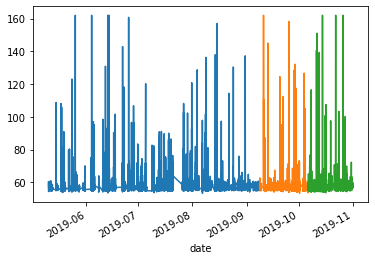

In [ ]:

train_set.set_index('date')['separator_pwr_kw_pv'].plot(label='train') 
validation_set.set_index('date')['separator_pwr_kw_pv'].plot(label='validation') 
test_set.set_index('date')['separator_pwr_kw_pv'].plot(label='test')


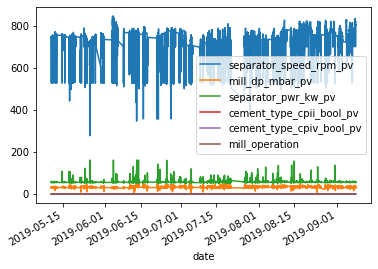

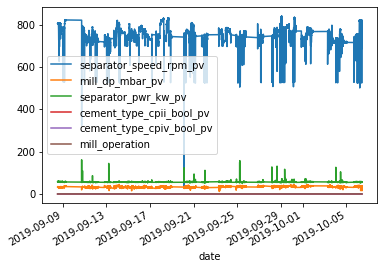

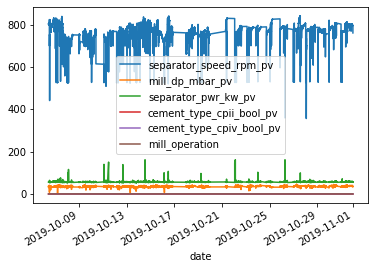

In [ ]:
train_set.set_index('date').plot(label='train') 
validation_set.set_index('date').plot(label='validation') 
test_set.set_index('date').plot(label='test')

plt.legend()

In [ ]:
preds = lr.predict(x_validation.iloc[0])

In [ ]:
y_pred = lr.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(mean_absolute_error(y_train, y_pred))
print(mean_absolute_percentage_error(y_train, y_pred))

4.161799950139969
0.6930962729145602
0.011586221441276062


In [ ]:
y_pred = model.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(mean_absolute_error(y_train, y_pred))
print(mean_absolute_percentage_error(y_train, y_pred))

0.4914966118461817
0.18125386518732287
0.0029984121348066886


In [ ]:
lr.score(y_pred,y_train)

C:\Users\msi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 10 features, but LinearRegression is expecting 120 features as input.

In [ ]:
from sklearn.inspection import permutation_importance

X = x_train
y = y_train

# Assuming you have X as the feature matrix and y as the target variable
regression_model = LinearRegression()
regression_model.fit(X, y)

# Calculate feature importances
result = permutation_importance(regression_model, X, y, n_repeats=10, random_state=42)
importances = result.importances_mean

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
sorted_importances = importance_df.sort_values('Importance', ascending=False)

# Print the most important features
print(sorted_importances.head())

                               Feature  Importance
119         mill_dp_mbar_pv_column_119    0.194355
118  separator_speed_rpm_pv_column_118    0.073768
15           mill_dp_mbar_pv_column_15    0.072190
17           mill_dp_mbar_pv_column_17    0.067954
13           mill_dp_mbar_pv_column_13    0.065866


In [ ]:
from sklearn.feature_selection import RFECV
 
X = x_train
y = y_train
 
# Assuming you have X as the feature matrix and y as the target variable
regression_model = LinearRegression()
 
# Perform recursive feature elimination
rfe = RFECV(regression_model)
rfe.fit(X, y)
 
# Get the ranking of features
feature_ranks = pd.Series(rfe.ranking_, index=X.columns)
 
# Sort features by rank (lower rank means higher importance)
sorted_features = feature_ranks.sort_values()
 
# Print the most important features
print(sorted_features.head(60))

mill_dp_mbar_pv_column_59            1
mill_dp_mbar_pv_column_75            1
mill_dp_mbar_pv_column_73            1
mill_dp_mbar_pv_column_71            1
mill_dp_mbar_pv_column_69            1
mill_dp_mbar_pv_column_67            1
mill_dp_mbar_pv_column_65            1
mill_dp_mbar_pv_column_63            1
mill_dp_mbar_pv_column_77            1
mill_dp_mbar_pv_column_61            1
mill_dp_mbar_pv_column_57            1
mill_dp_mbar_pv_column_55            1
mill_dp_mbar_pv_column_53            1
mill_dp_mbar_pv_column_51            1
mill_dp_mbar_pv_column_49            1
mill_dp_mbar_pv_column_47            1
mill_dp_mbar_pv_column_45            1
separator_speed_rpm_pv_column_118    1
mill_dp_mbar_pv_column_79            1
mill_dp_mbar_pv_column_81            1
mill_dp_mbar_pv_column_83            1
mill_dp_mbar_pv_column_117           1
mill_dp_mbar_pv_column_115           1
mill_dp_mbar_pv_column_113           1
mill_dp_mbar_pv_column_111           1
mill_dp_mbar_pv_column_10

In [ ]:
x_train

,separator_speed_rpm_pv_column_0,mill_dp_mbar_pv_column_1,separator_speed_rpm_pv_column_2,mill_dp_mbar_pv_column_3,separator_speed_rpm_pv_column_4,mill_dp_mbar_pv_column_5,separator_speed_rpm_pv_column_6,mill_dp_mbar_pv_column_7,separator_speed_rpm_pv_column_8,mill_dp_mbar_pv_column_9,separator_speed_rpm_pv_column_10,mill_dp_mbar_pv_column_11,separator_speed_rpm_pv_column_12,mill_dp_mbar_pv_column_13,separator_speed_rpm_pv_column_14,mill_dp_mbar_pv_column_15,separator_speed_rpm_pv_column_16,mill_dp_mbar_pv_column_17,separator_speed_rpm_pv_column_18,mill_dp_mbar_pv_column_19,separator_speed_rpm_pv_column_20,mill_dp_mbar_pv_column_21,separator_speed_rpm_pv_column_22,mill_dp_mbar_pv_column_23,separator_speed_rpm_pv_column_24,mill_dp_mbar_pv_column_25,separator_speed_rpm_pv_column_26,mill_dp_mbar_pv_column_27,separator_speed_rpm_pv_column_28,mill_dp_mbar_pv_column_29,separator_speed_rpm_pv_column_30,mill_dp_mbar_pv_column_31,separator_speed_rpm_pv_column_32,mill_dp_mbar_pv_column_33,separator_speed_rpm_pv_column_34,mill_dp_mbar_pv_column_35,separator_speed_rpm_pv_column_36,mill_dp_mbar_pv_column_37,separator_speed_rpm_pv_column_38,mill_dp_mbar_pv_column_39
2,612.65000,36.50500,591.62500,35.41375,528.550,32.1400,549.94500,32.8100,614.13000,34.82000,635.81625,34.51000,700.8750,33.580,700.92750,33.435,701.08500,33.000,709.15875,32.830,733.38000,32.3200,733.33375,32.1900,733.19500,31.8000,737.88875,31.67250,751.970,31.29000,751.785,31.22375,751.2300,31.02500,749.3350,31.10125,743.65000,31.33000,741.48500,31.20875
3,591.62500,35.41375,528.55000,32.14000,549.945,32.8100,614.13000,34.8200,635.81625,34.51000,700.87500,33.58000,700.9275,33.435,701.08500,33.000,709.15875,32.830,733.38000,32.320,733.33375,32.1900,733.19500,31.8000,737.88875,31.6725,751.97000,31.29000,751.785,31.22375,751.230,31.02500,749.3350,31.10125,743.6500,31.33000,741.48500,31.20875,734.99000,30.84500
4,528.55000,32.14000,549.94500,32.81000,614.130,34.8200,635.81625,34.5100,700.87500,33.58000,700.92750,33.43500,701.0850,33.000,709.15875,32.830,733.38000,32.320,733.33375,32.190,733.19500,31.8000,737.88875,31.6725,751.97000,31.2900,751.78500,31.22375,751.230,31.02500,749.335,31.10125,743.6500,31.33000,741.4850,31.20875,734.99000,30.84500,734.89750,30.54375
24,734.62000,29.64000,722.46125,30.23750,685.985,32.0300,689.59500,31.9775,700.42500,31.82000,704.67000,31.73625,717.4050,31.485,721.94000,31.360,735.54500,30.985,735.24750,30.830,734.35500,30.3650,734.34250,30.2925,734.30500,30.0750,738.61000,30.30750,751.525,31.00500,739.535,31.41625,703.5650,32.65000,703.2225,32.91000,702.19500,33.69000,709.83875,33.72625
25,722.46125,30.23750,685.98500,32.03000,689.595,31.9775,700.42500,31.8200,704.67000,31.73625,717.40500,31.48500,721.9400,31.360,735.54500,30.985,735.24750,30.830,734.35500,30.365,734.34250,30.2925,734.30500,30.0750,738.61000,30.3075,751.52500,31.00500,739.535,31.41625,703.565,32.65000,703.2225,32.91000,702.1950,33.69000,709.83875,33.72625,732.77000,33.83500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16266,717.25000,36.80000,718.04000,36.50000,732.980,36.2800,751.68000,36.9900,751.68000,36.61000,752.26000,36.77000,751.9400,36.780,752.21000,36.960,751.21000,37.090,751.15000,37.330,751.05000,37.2400,750.99000,37.3400,751.63000,37.3900,750.73000,37.36000,751.940,37.67000,752.020,37.81250,750.8900,37.93000,752.2600,38.24000,751.89000,38.31000,751.94000,38.54000
16267,718.04000,36.50000,732.98000,36.28000,751.680,36.9900,751.68000,36.6100,752.26000,36.77000,751.94000,36.78000,752.2100,36.960,751.21000,37.090,751.15000,37.330,751.05000,37.240,750.99000,37.3400,751.63000,37.3900,750.73000,37.3600,751.94000,37.67000,752.020,37.81250,750.890,37.93000,752.2600,38.24000,751.8900,38.31000,751.94000,38.54000,750.99000,38.72000
16268,732.98000,36.28000,751.68000,36.99000,751.680,36.6100,752.26000,36.7700,751.94000,36.78000,752.21000,36.96000,751.2100,37.090,751

In [ ]:
x_train.describe()

,separator_speed_rpm_pv_column_0,mill_dp_mbar_pv_column_1,separator_speed_rpm_pv_column_2,mill_dp_mbar_pv_column_3,separator_speed_rpm_pv_column_4,mill_dp_mbar_pv_column_5,separator_speed_rpm_pv_column_6,mill_dp_mbar_pv_column_7,separator_speed_rpm_pv_column_8,mill_dp_mbar_pv_column_9,separator_speed_rpm_pv_column_10,mill_dp_mbar_pv_column_11,separator_speed_rpm_pv_column_12,mill_dp_mbar_pv_column_13,separator_speed_rpm_pv_column_14,mill_dp_mbar_pv_column_15,separator_speed_rpm_pv_column_16,mill_dp_mbar_pv_column_17,separator_speed_rpm_pv_column_18,mill_dp_mbar_pv_column_19
count,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000,15409.000000
mean,756.948427,34.349758,756.959601,34.359833,757.110372,34.373484,757.708702,34.395719,758.352733,34.414427,759.080304,34.429933,759.778781,34.446004,760.421595,34.461490,760.985372,34.474877,761.412131,34.482283
std,50.383918,3.612991,50.224825,3.615921,50.096316,3.617430,48.953576,3.598084,47.764355,3.586558,46.360663,3.578586,45.089520,3.576190,43.925042,3.579669,43.041733,3.585311,42.464937,3.593233
min,356.800000,3.120000,357.012500,3.120000,357.065000,3.120000,357.065000,3.120000,357.065000,3.280000,357.065000,10.320000,357.065000,15.670000,357.065000,20.080000,357.065000,22.690000,357.065000,24.730000
25%,742.280000,31.582500,742.280000,31.595000,742.320000,31.615000,742.385000,31.632500,742.458750,31.650000,742.558750,31.660000,742.685000,31.672500,742.810000,31.682500,743.150000,31.695000,745.080000,31.690000
50%,767.710000,34.360000,767.710000,34.365000,767.722500,34.370000,767.735000,34.380000,767.740000,34.385000,767.753750,34.390000,767.765000,34.390000,767.790000,34.400000,767.790000,34.410000,767.790000,34.411250
75%,785.640000,36.530000,785.640000,36.540000,785.687500,36.550000,785.692500,36.560000,785.735000,36.560000,785.770000,36.567500,785.820000,36.570000,785.850000,36.580000,785.858750,36.585000,785.895000,36.590000
max,846.270000,51.410000,846.270000,51.410000,846.585000,51.410000,846.585000,51.410000,846.585000,51.410000,846.585000,51.410000,846.585000,51.430000,846.585000,52.370000,846.585000,52.370000,846.585000,52.370000


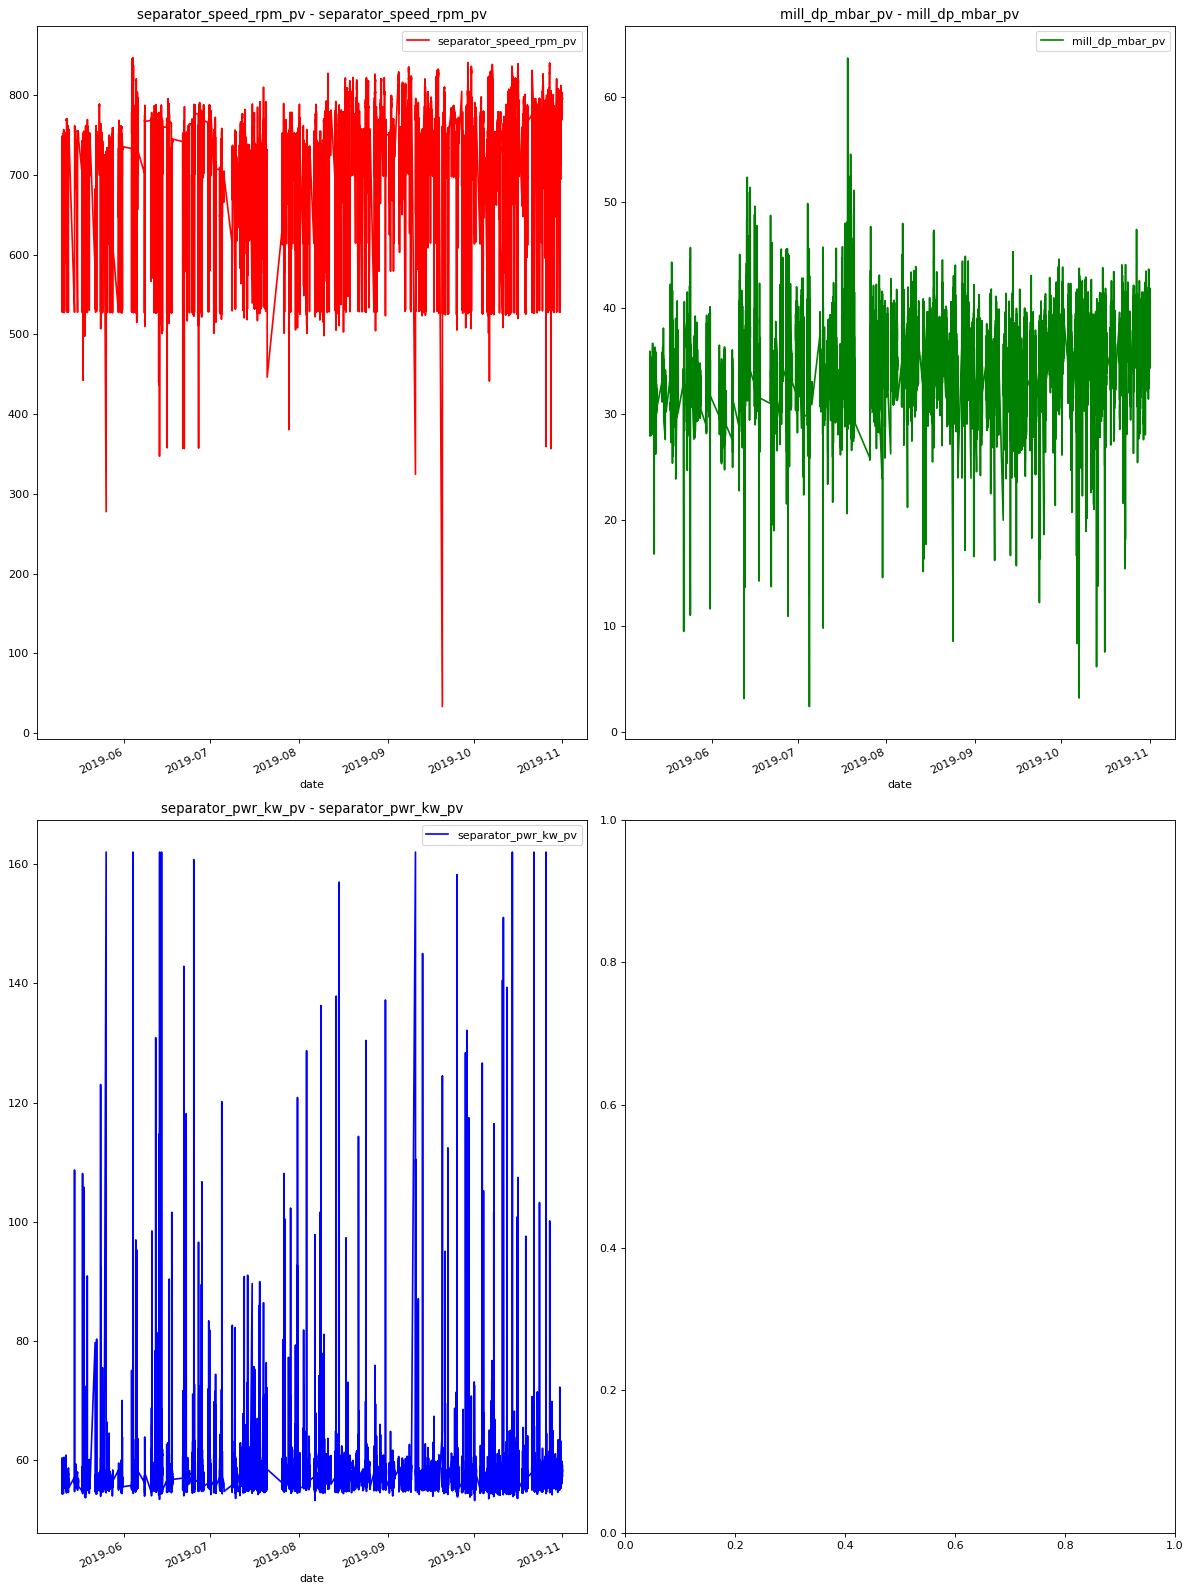

In [ ]:
feature_keys = [
    "separator_speed_rpm_pv",
    "mill_dp_mbar_pv",
    "separator_pwr_kw_pv"
]

titles = feature_keys

date_time_key = "date"
colors = ["red", "green", "blue", "grey"]
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(filtered_df)

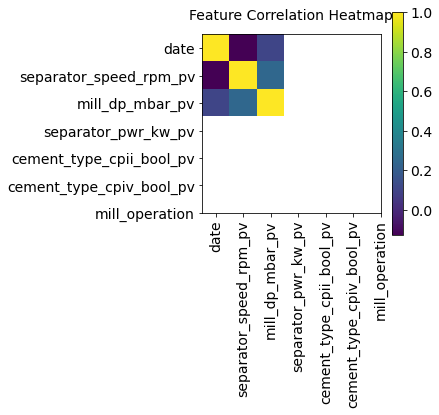

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(filtered_df)

### RNN (new)

In [ ]:
stopp

NameError: name 'h' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

param_dist = {
    'n_estimators': [250],
    'min_samples_split': [6],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the RandomForestRegressor model
model = RandomForestRegressor(criterion='absolute_error')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring='neg_mean_absolute_error',
                                   n_iter=10)  # adjust the n_iter value as per your preference
random_search.fit(x_train, y_train)

# Get the best model with the optimized hyperparameters
best_model = random_search.best_estimator_

# Step 3: Cross-Validation
# Use k-fold cross-validation to evaluate the model
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Step 4: Fit and Evaluate
# Fit the model using the optimized hyperparameters
best_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(x_test)

# Evaluate the model using appropriate metrics
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

C:\Users\msi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
features = june_first.drop(['date'], axis=1)
features.index = june_first[date_time_key]

split_fraction = 0.715
train_split = int(split_fraction * int(june_first.shape[0]))
step = 1

past = 20
future = 10 #after 10 timestamps
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [ ]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[2]]

sequence_length = int(past / step)

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
correlation_matrix = june_first.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
shifted_df = june_first[['separator_speed_rpm_pv', 'mill_dp_mbar_pv']].shift(10)

# Concatenate the shifted columns with the original dataframe
shifted_df = pd.concat([june_first.drop(['separator_speed_rpm_pv', 'mill_dp_mbar_pv'] , axis=1), shifted_df], axis=1)

# Drop rows with NaN values introduced by the shifting
shifted_df = shifted_df.dropna()

# Print the resulting dataframe with shifted columns
print(shifted_df)

In [ ]:
correlation_matrix = shifted_df.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv']

june_first = extractUsefulInfo(june,columns)
june_first['date'] = june['date']

In [ ]:
july = df_list[2]
july_first = extractUsefulInfo(july,columns)
july_first

In [ ]:
q_low = 0.01
q_hi = 0.99
plots(june_first,'mill_dp_mbar_pv',q_low,q_hi)


In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_pwr_kw_pv',q_low,q_hi)

In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_speed_rpm_pv',q_low,q_hi)

In [ ]:
# Normalize data
sc = StandardScaler()
X = june_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y = june_first['separator_speed_rpm_pv']
X_test = july_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y_test =  july_first['separator_speed_rpm_pv']

X = sc.fit_transform(X)
X_test= sc.transform(X_test)


In [ ]:
# Linear Regression
model = LinearRegression()


model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# RandomForest Regressor

# My max_depth=16
param_grid = {
    'n_estimators' : [10, 50, 100, 200, 1000],
    'criterion' : ['squared_error','absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [None, 4, 8, 12],
    'min_samples_split' : [2, 5, 8]
}
model = RandomForestRegressor()

gs = GridSearchCV(model,param_grid,scoring='neg_mean_squared_error',verbose=10,n_jobs =-1)
#gs.fit(X,y)
model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# IGNORE einai gia to deutero, apla evlepa.

columns = ['total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv',
           'main_fan_speed_rpm_pv', 'separator_speed_rpm_pv', 'grinding_pressure_bar_pv',
           'mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 'mill_dp_mbar_pv']

second = extractUsefulInfo(june,columns)